# A simple 1D model implementation


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.model import NoTransportModel
from seapopym.standard import coordinates
from seapopym.standard.units import StandardUnitsLabels


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. In this NoTransport model, only temperature and primary production are required. The temperature is generated as a sine wave with a period of 1 year and the primary production is randomly generated.


/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:1: DeprecationWarning: new_time() is deprecated. Use CoordinateAuthority registry instead.
  T_axis = coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:10: DeprecationWarning: new_time() is deprecated. Use CoordinateAuthority registry instead.
  "T": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:11: DeprecationWarning: new_latitude() is deprecated. Use CoordinateAuthority registry instead.
  "Y": coordinates.new_latitude([0]),
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:12: DeprecationWarning: new_longitude() is deprecated. Use CoordinateAuthority registry instead.
  "X": coordinates.new_longitude([0]),
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376

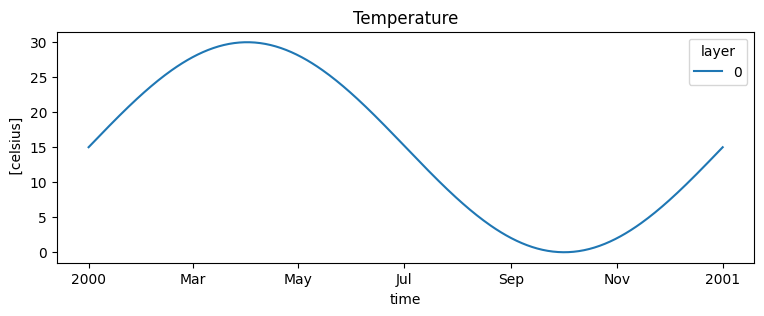

/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:27: DeprecationWarning: new_time() is deprecated. Use CoordinateAuthority registry instead.
  "T": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:28: DeprecationWarning: new_latitude() is deprecated. Use CoordinateAuthority registry instead.
  "Y": coordinates.new_latitude([0]),
/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_47376/4182692182.py:29: DeprecationWarning: new_longitude() is deprecated. Use CoordinateAuthority registry instead.
  "X": coordinates.new_longitude([0]),


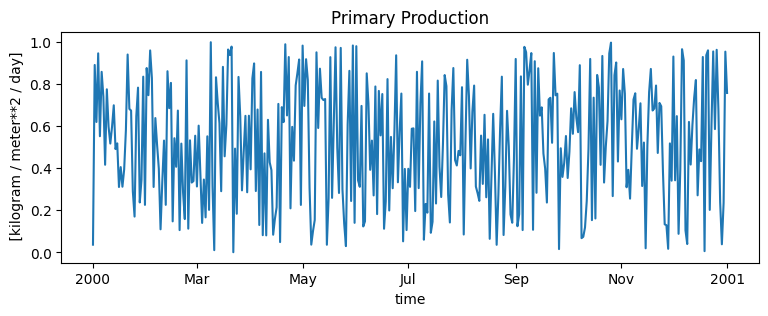

In [2]:
T_axis = coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(T_axis.size)
t = np.linspace(0, 1, n)
temperature = 15 + 15 * np.sin(2 * np.pi * t)
primary_production = 10 + 5 * np.sin(2 * np.pi * t * 365)

temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": coordinates.new_latitude([0]),
        "X": coordinates.new_longitude([0]),
        "Z": coordinates.new_layer([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": coordinates.new_latitude([0]),
        "X": coordinates.new_longitude([0]),
    },
    attrs={"units": StandardUnitsLabels.production},
    data=np.random.rand(367, 1, 1),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production})

## Initialize the model

First we set up the model parameters. We will define a single functional group with the commonly used parameters for the zooplankton in Seapodym LMTL.


In [3]:
day_layer = 0
night_layer = 0
tr_0 = 10.38
gamma_tr = -0.11
lambda_temperature_0 = 1 / 150
gamma_lambda_temperature = 0.15

f_groups = FunctionalGroupParameter(
    functional_group=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            energy_transfert=0.1668,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0,
                gamma_lambda_temperature=gamma_lambda_temperature,
                tr_0=tr_0,
                gamma_tr=gamma_tr,
            ),
        ),
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}_BIS",
            energy_transfert=0.1668 / 2,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0 / 2,
                gamma_lambda_temperature=gamma_lambda_temperature / 2,
                tr_0=tr_0 / 2,
                gamma_tr=gamma_tr / 2,
            ),
        ),
    ]
)

p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
)

parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

## Run the model with context manager

The new recommended way to use Seapopym models is with a context manager. This ensures automatic memory cleanup after model execution, which is especially important for genetic algorithms or repeated simulations.


In [4]:
# Recommended: Using context manager for automatic memory cleanup
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    # Extract results while still in context
    biomass = model.state["biomass"].copy()  # Important: copy() for external use
    display(model.state)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:350: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fill_value = asarray(fill_value)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates, combine_attrs="no_conflicts")
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the defaul

<xarray.Dataset> Size: 50kB
Dimensions:                       (functional_group: 2, T: 367, Y: 1, X: 1,
                                   cohort: 11, Z: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * T                             (T) datetime64[ns] 3kB 2000-01-01 ... 2001-...
  * Y                             (Y) int64 8B 0
  * X                             (X) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * Z                             (Z) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, T, Y, X) float64 6kB 0.0...
    recruited                     (functional_group, T, Y, X) float64 6kB 0.0...
    mortality_field               (functional_group, T, Y, X) float64 6kB 0.9...
    mask_temperature              (functional_group, T, Y, X, cohort) bool 8kB ...
    min_temperature               (functional_group, cohort) float64 176B 21....
    primary_production_by_fgroup  (functional_group, T, Y, X) float64 6kB 0.0...
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 176B 1.0...
    mean_timestep                 (functional_group, cohort) float64 176B 1.0...
    timestep                      float64 8B 1.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

## Plotting the results

### The biomass evolution over T


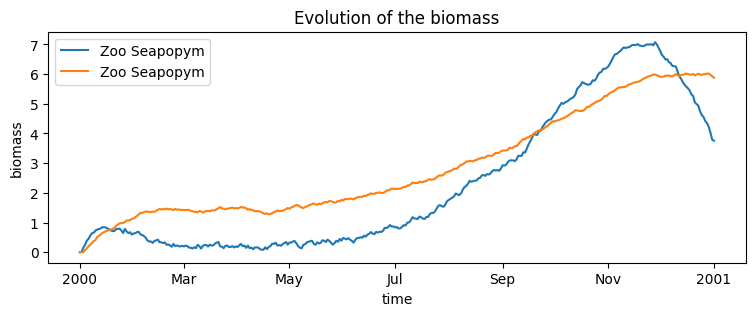

In [5]:
plt.figure(figsize=(9, 3))
biomass.mean(["Y", "X"]).plot(label="Zoo Seapopym", x="T", hue="functional_group")
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

## And now let's do it in parallel


In [6]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51922,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:51934,Total threads: 3
Dashboard: http://127.0.0.1:51939/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51925,


In [7]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"].chunk()),
    primary_production=ForcingUnit(forcing=dataset["primary_production"].chunk()),
    parallel=True,
)
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

In [8]:
# Run parallel model with context manager
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    # Extract results for plotting
    parallel_biomass = model.state["biomass"].load().copy()
    display(model.state)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:350: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fill_value = asarray(fill_value)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates, combine_attrs="no_conflicts")
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the defaul

<xarray.Dataset> Size: 50kB
Dimensions:                       (functional_group: 2, T: 367, Y: 1, X: 1,
                                   cohort: 11, Z: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * T                             (T) datetime64[ns] 3kB 2000-01-01 ... 2001-...
  * Y                             (Y) int64 8B 0
  * X                             (X) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * Z                             (Z) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, T, Y, X) float64 6kB 0.0...
    recruited                     (functional_group, T, Y, X) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    mortality_field               (functional_group, T, Y, X) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    mask_temperature              (functional_group, T, Y, X, cohort) bool 8kB dask.array<chunksize=(1, 367, 1, 1, 11), meta=np.ndarray>
    min_temperature               (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    primary_production_by_fgroup  (functional_group, T, Y, X) float64 6kB dask.array<chunksize=(1, 367, 1, 1), meta=np.ndarray>
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    mean_timestep                 (functional_group, cohort) float64 176B dask.array<chunksize=(1, 11), meta=np.ndarray>
    timestep                      float64 8B 1.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

### The biomass evolution over T


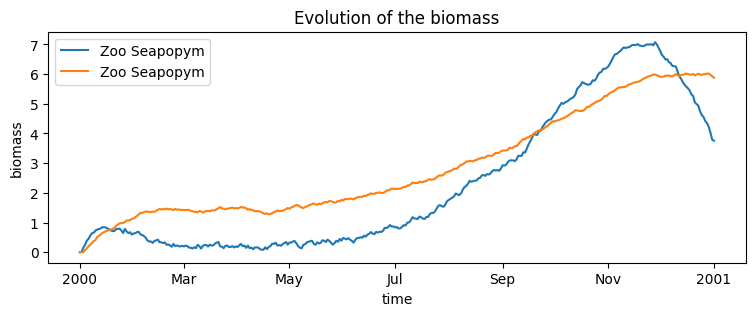

In [9]:
plt.figure(figsize=(9, 3))
parallel_biomass.mean(["Y", "X"]).plot(label="Zoo Seapopym", x="T", hue="functional_group")
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

# Show weekly model configuration


In [10]:
weekly_dataset = dataset.resample(T="1W").mean().interpolate_na()
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=weekly_dataset["temperature"]),
    primary_production=ForcingUnit(forcing=weekly_dataset["primary_production"]),
)
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

In [11]:
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    weekly_biomass = model.state["biomass"].load().copy()
    display(model.state)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:350: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fill_value = asarray(fill_value)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates, combine_attrs="no_conflicts")
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the defaul

<xarray.Dataset> Size: 7kB
Dimensions:                       (functional_group: 2, T: 54, Y: 1, X: 1,
                                   cohort: 2, Z: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * T                             (T) datetime64[ns] 432B 2000-01-02 ... 2001...
  * Y                             (Y) int64 8B 0
  * X                             (X) int64 8B 0
  * cohort                        (cohort) int64 16B 0 1
  * Z                             (Z) int64 8B 0
Data variables: (12/28)
    biomass                       (functional_group, T, Y, X) float64 864B 0....
    recruited                     (functional_group, T, Y, X) float64 864B 0....
    mortality_field               (functional_group, T, Y, X) float64 864B 0....
    mask_temperature              (functional_group, T, Y, X, cohort) bool 216B ...
    min_temperature               (functional_group, cohort) float64 32B 3.58...
    primary_production_by_fgroup  (functional_group, T, Y, X) float64 864B 0....
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 32B 7.0 ...
    mean_timestep                 (functional_group, cohort) float64 32B 7.0 ...
    timestep                      float64 8B 7.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

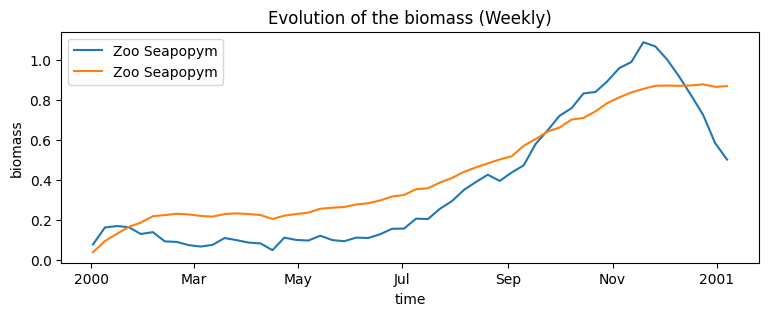

In [12]:
plt.figure(figsize=(9, 3))
weekly_biomass.mean(["Y", "X"]).plot(label="Zoo Seapopym", x="T", hue="functional_group")
plt.legend()
plt.title("Evolution of the biomass (Weekly)")
plt.show()